## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import os
from glob import glob
from itertools import chain

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,auc,precision_recall_curve,average_precision_score
from sklearn.metrics import f1_score, recall_score

from random import sample 

import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import RMSprop
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, BatchNormalization, AveragePooling2D

import matplotlib.pyplot as plt
%matplotlib inline
##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation

all_xray_df = pd.read_csv('data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
111059,00030317_000.png,No Finding,0,30317,74,F,PA,2021,2021,0.194311,0.194311,NaN,data/images_012/images/00030317_000.png
109222,00029680_001.png,Infiltration,1,29680,35,M,AP,3056,2544,0.139000,0.139000,NaN,data/images_012/images/00029680_001.png
107952,00029200_001.png,No Finding,1,29200,59,M,PA,2021,2021,0.194311,0.194311,NaN,data/images_012/images/00029200_001.png


In [3]:
labels = all_xray_df["Finding Labels"].unique()
print(len(labels))
print(len([l for l in labels if "Pneumonia" in l]))

836
142


In [4]:
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
all_labels

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'No Finding',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

In [5]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

def new_class(df, dis):
    cls = (dis+"_class").lower()
    df[cls] = 0
    c = df[cls].copy()
    c[df['Finding Labels'].str.contains(dis)] = 1
    df[cls] = c
    return df

for dis in all_labels:
    new_class(all_xray_df, dis)
all_xray_df    

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,emphysema_class,fibrosis_class,hernia_class,infiltration_class,mass_class,no finding_class,nodule_class,pleural_thickening_class,pneumonia_class,pneumothorax_class
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1,0,0,0,0,0,0,0,0,0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0,0,0,0,0,1,0,0,0,0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,...,0,0,0,0,1,0,0,0,1,0
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,...,0,0,0,0,0,1,0,0,0,0
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,...,0,0,0,0,0,1,0,0,0,0
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,...,0,0,0,0,0,1,0,0,0,0


In [6]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

#Done above for all diseases

# Todo
# Todo
# all_xray_df['pneumonia_class'] = 0
# c = all_xray_df['pneumonia_class'].copy()
# c[all_xray_df['Finding Labels'].str.contains('Pneumonia')] = 1
# all_xray_df['pneumonia_class'] = c
# all_xray_df

## Create your training and testing data:

In [7]:
def create_splits(vargs):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # Todo
    df = vargs[0]
    test_size = vargs[1]
    column_name = vargs[2]
    
    train_data, val_data = train_test_split(df, test_size=test_size,
                                           stratify = df[column_name])
    
    return train_data, val_data

train_df, valid_df = create_splits((all_xray_df, 0.2, 'pneumonia_class'))

In [8]:
train_df['pneumonia_class'].sum()/len(train_df)

0.012765340706386016

In [9]:
valid_df['pneumonia_class'].sum()/len(valid_df)

0.012754191937210132

In [10]:
p_inds = train_df[train_df.pneumonia_class==1].index.tolist()
np_inds = train_df[train_df.pneumonia_class==0].index.tolist()

np_sample = sample(np_inds,len(p_inds))
train_df = train_df.loc[p_inds + np_sample]

In [11]:
train_df['pneumonia_class'].sum()/len(train_df)

0.5

In [12]:
p_inds = valid_df[valid_df.pneumonia_class==1].index.tolist()
np_inds = valid_df[valid_df.pneumonia_class==0].index.tolist()

np_sample = sample(np_inds,4*len(p_inds))
valid_df = valid_df.loc[p_inds + np_sample]

In [13]:
valid_df['pneumonia_class'].sum()/len(valid_df)

0.2

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [14]:
def my_image_augmentation():
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo
    my_idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=20, 
                              shear_range = 0.1,
                              zoom_range=0.1)

    return my_idg


def make_train_gen(train_df, img_size, batch_size):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
     # Todo
    idg = my_image_augmentation()        
    train_gen = idg.flow_from_dataframe(dataframe=train_df, 
                                             directory=None, 
                                             x_col = "path",
                                             y_col = "pneumonia_class",
                                             class_mode = 'raw',
                                             target_size = img_size, 
                                             batch_size = batch_size
                                             )
    return train_gen

def make_val_gen(val_data, img_size, batch_size):
    my_val_idg = ImageDataGenerator(rescale=1./255.)
    val_gen = my_val_idg.flow_from_dataframe(dataframe = val_data, 
                                             directory=None, 
                                             x_col = "path",
                                             y_col = "pneumonia_class",
                                             class_mode = 'raw',
                                             target_size = img_size, 
                                             batch_size = batch_size) 
    
    # Todo
    return val_gen

batch_size = 64
img_size = (224, 224)

train_gen = make_train_gen(train_df, img_size, batch_size)
val_gen = make_val_gen(valid_df, img_size, batch_size)

Found 2290 validated image filenames.
Found 1430 validated image filenames.


In [15]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

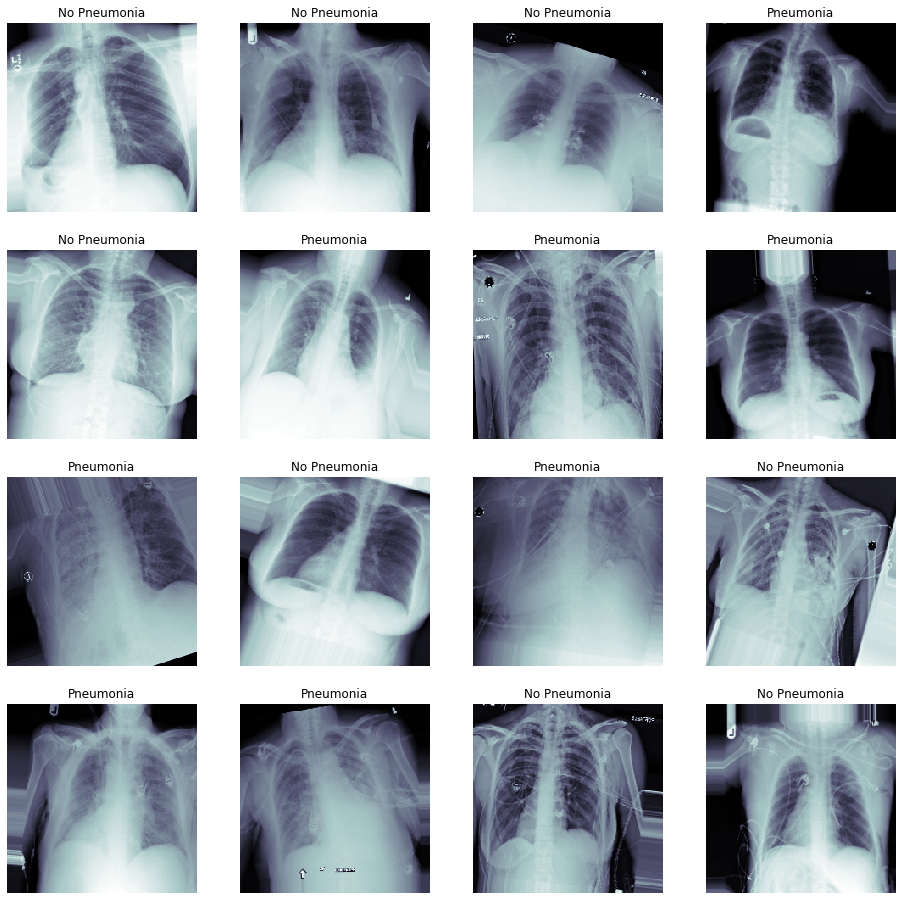

In [16]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [17]:
def load_pretrained_model():
    
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    for layer in vgg_model.layers[0:17]:
        layer.trainable = False
    # Todo
    
    return vgg_model

In [18]:
def build_my_model():
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo
    new_model = Sequential()
    vgg_model = load_pretrained_model()
    # Add the convolutional part of the VGG16 model from above.
    new_model.add(vgg_model)

    # Flatten the output of the VGG16 model because it is from a
    # convolutional layer.
    new_model.add(Flatten())

    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data e.g. the test-set.
    new_model.add(Dropout(0.5))

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    new_model.add(Dense(1024, activation='relu'))

    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data e.g. the test-set.
    new_model.add(Dropout(0.5))

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    new_model.add(Dense(512, activation='relu'))

    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data e.g. the test-set.
    new_model.add(Dropout(0.5))

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    new_model.add(Dense(256, activation='relu'))

    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data e.g. the test-set.
    new_model.add(Dropout(0.5))

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    new_model.add(Dense(1, activation='sigmoid'))
    
    return new_model

def build_my_model2():
    
    backbone = load_pretrained_model()

    model = Sequential([backbone,
                        Conv2D(1024, 1, activation='relu'),
                        Dropout(0.5),
                        AveragePooling2D((7,7)),
                        Conv2D(1, 1, activation='sigmoid')
                       ])
    model.add(Dense(1, activation='relu'))
    return model

my_model = build_my_model()
my_model.summary()

## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)              

In [19]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= "val_loss", 
                             verbose=1, 
                             save_best_only=True, 
                             mode= "auto", 
                             save_weights_only = True)

early = EarlyStopping(monitor= "val_loss", 
                      mode= "auto", 
                      patience=10)
def scheduler(epoch, lr):
    print("learning rate %.2E"%lr)
    if epoch < 2:
        return lr
    else:
        return lr * np.exp(-0.1)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

callbacks_list = [checkpoint, early]

### Start training! 

In [20]:
## train your model

# Todo
optimizer=Adam(lr=1e-3)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']

my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
history = my_model.fit_generator(train_gen, 
                          validation_data = val_gen, 
                          epochs = 10, 
                          callbacks = callbacks_list)

Epoch 1/10
36/36 [==============================] - 85s 2s/step - loss: 0.8448 - binary_accuracy: 0.5262 - val_loss: 0.6896 - val_binary_accuracy: 0.5755

Epoch 00001: val_loss improved from inf to 0.68956, saving model to xray_class_my_model.best.hdf5
Epoch 2/10
36/36 [==============================] - 38s 1s/step - loss: 0.6885 - binary_accuracy: 0.5520 - val_loss: 0.6771 - val_binary_accuracy: 0.4916

Epoch 00002: val_loss improved from 0.68956 to 0.67706, saving model to xray_class_my_model.best.hdf5
Epoch 3/10
36/36 [==============================] - 42s 1s/step - loss: 0.6819 - binary_accuracy: 0.5598 - val_loss: 0.6937 - val_binary_accuracy: 0.5175

Epoch 00003: val_loss did not improve from 0.67706
Epoch 4/10
36/36 [==============================] - 41s 1s/step - loss: 0.6744 - binary_accuracy: 0.5742 - val_loss: 0.6900 - val_binary_accuracy: 0.5042

Epoch 00004: val_loss did not improve from 0.67706
Epoch 5/10
36/36 [==============================] - 42s 1s/step - loss: 0.6806

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [51]:
import multiprocessing as mp
cpu_count = mp.cpu_count()
print("cpu count", cpu_count)

cpu count 8


In [53]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
val_Y = valid_df['pneumonia_class']
my_model.load_weights(weight_path)
pred_Y = my_model.predict(val_gen, verbose = True)

23/23 [==============================] - 15s 663ms/step


In [103]:
def plot_auc(val_Y, pred_Y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    # Todo
    fpr, tpr, threshold = roc_curve(val_Y, pred_Y)
    roc_auc = auc(fpr, tpr)
    
    plt.title('Plot AUC')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

    return

def plot_prec_rec(val_Y, pred_Y):
    prec, rec, threshold = precision_recall_curve(val_Y, pred_Y)
    plt.title('Plot Precision Recall')
    plt.plot(prec, rec, 'b', label = 'score = %0.2f' % average_precision_score(val_Y,pred_Y))
    plt.legend(loc = 'upper right')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.show()


## what other performance statistics do you want to include here besides AUC? 


# def ... 
# Todo

# def ...
# Todo
    
#Also consider plotting the history of your model training:

def plot_history(history):
    
    # Todo
    n = len(history.history["loss"])
    plt.figure()
    plt.plot(np.arange(n), history.history["loss"], label="train_loss")
    plt.plot(np.arange(n), history.history["val_loss"], label="val_loss")
    plt.title("Training Loss on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")
    return
    
    return




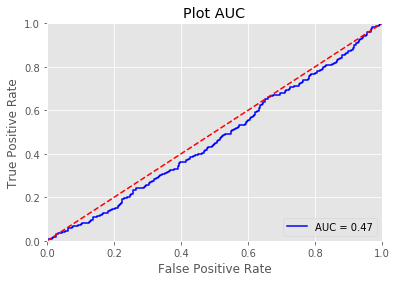

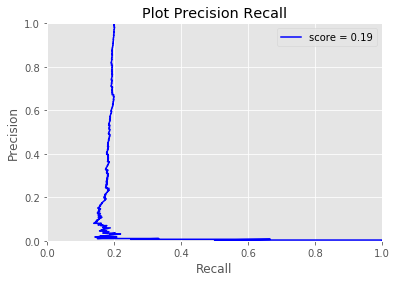

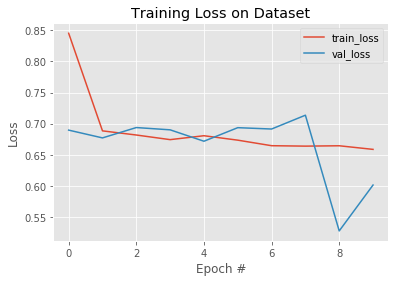

In [104]:
## plot figures

# Todo
plot_auc(val_Y, pred_Y)
plot_prec_rec(val_Y, pred_Y)
plot_history(history)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [127]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo
def optimize_accuracy(t_y, p_y):
    best_threshold = None
    best_accuracy = 0.
    for t in np.arange(0.5,1,0.1):
        pred = (p_y.reshape(-1)>t)*1.
        accuracy = np.mean(pred==t_y)
        if accuracy > best_accuracy:
            best_threshold = t
            best_accuracy = accuracy
    return best_threshold, best_accuracy
best_threshold, best_accuracy = optimize_accuracy(val_Y, pred_Y)
print("Threshold of %.2f gives best accuracy at %.4f"%(best_threshold, best_accuracy))

Threshold of 0.90 gives best accuracy at 0.8007


In [128]:
pred_Y_class = pred_Y > best_threshold
f1_score(val_Y, pred_Y_class)

0.006968641114982578

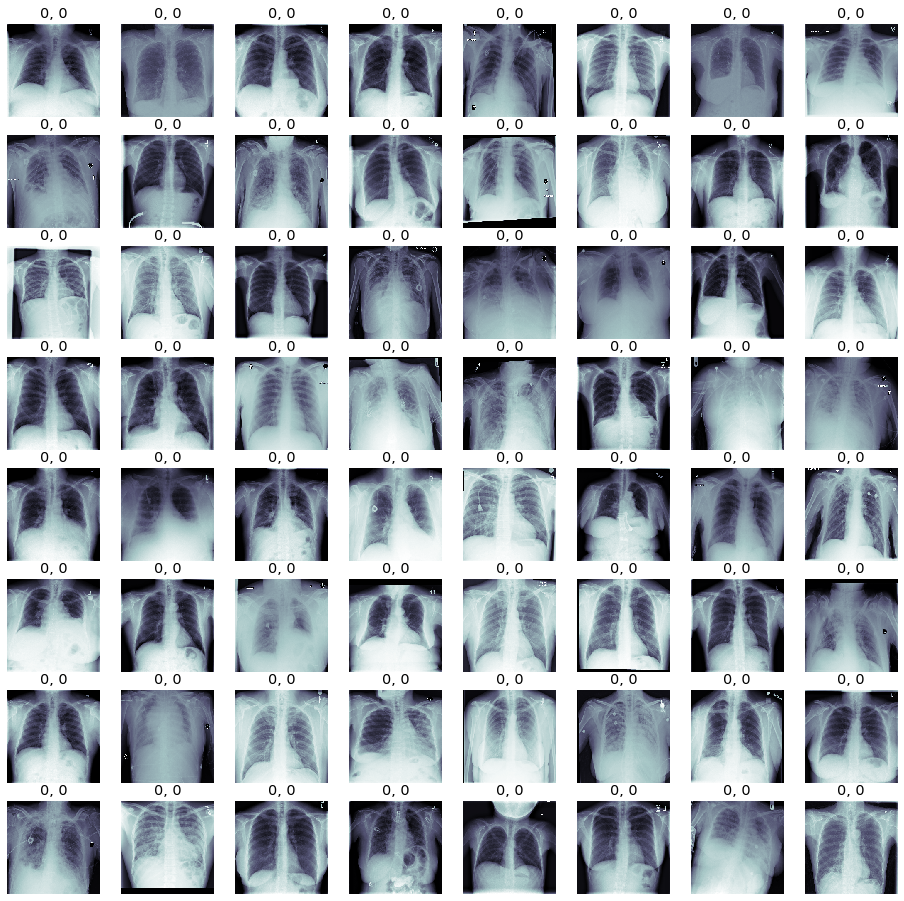

In [139]:
# Let's look at some examples of predicted v. true with our best model: 

fig, m_axs = plt.subplots(8, 8, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:64], pred_Y[0:64], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > best_threshold:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > best_threshold: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [140]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)